# **InceptionV3**



**Import Necessary Libraries and Data**

In [ ]:
# To store and process in a dataframe
import pandas as pd
# Advancec ploting
import seaborn as sns
# For ploting graphs
import matplotlib.pyplot as plt
# For numerical analysis
import numpy as np
from numpy import argmax, array_equal
# Layers
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, Dropout, Flatten, MaxPooling2D
# Train test split
from sklearn.model_selection import train_test_split
# Stop the training when there is no improvement in the loss for three consecutive epochs
from keras.callbacks import EarlyStopping
# Model performance metrics
from sklearn.metrics import classification_report
# Utility functions
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# Sequential model
from tensorflow.keras.models import Sequential, Model
from imgaug import augmenters
from random import randint
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization


In [ ]:
# Remove any file and Delete .kaggle directory
!rm -r ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
# Install Kaggle
!pip install -q kaggle

In [ ]:
# To upload kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaveeshahiruni","key":"e55502de6f913d6e141e149a78974607"}'}

In [ ]:
# To save this file into a directory
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# To change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the food MNIST dataset from Kaggle
!kaggle datasets download -d utkarshsaxenadn/fast-food-classification-dataset

 98% 801M/821M [00:11<00:00, 94.3MB/s]
100% 821M/821M [00:11<00:00, 73.7MB/s]


In [ ]:
# Extract the files in the zip file
!unzip -n 'fast-food-classification-dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (10).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (100).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1000).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1001).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1002).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1003).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1004).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1005).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1006).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1007).jpeg  
  inflating: Fast Food Classification V2/T

In [ ]:
ROOT_PATH = '/content/Fast Food Classification V2'
training_path = f'{ROOT_PATH}/Train'
validation_path = f'{ROOT_PATH}/Test'
evaluation_path = f'{ROOT_PATH}/Valid'

In [ ]:
# Function to load and convert images to RGBA format
def load_and_convert_to_rgba(image_path):
    image = Image.open(image_path)
    if image.mode != "RGBA":
        image = image.convert("RGBA")
    return np.array(image)

# Example usage in the data generator:
def generator_with_rgba_conversion(generator):
    for batch_x, batch_y in generator:
        batch_x_rgba = [load_and_convert_to_rgba(image_path) for image_path in generator.filenames]
        yield (np.array(batch_x_rgba), batch_y)


**Data Preprocessing** : Before training a model, it is needed to preprocess data. This includes loading and augmenting the images

In [ ]:
# Define data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # Increase rotation range
    width_shift_range=0.2,  # Increase shift range
    height_shift_range=0.2,
    shear_range=0.2,  # Increase shear range
    zoom_range=0.2,  # Increase zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Define data augmentation for validation and test images
validation_datagen = ImageDataGenerator(rescale=1./255)
evaluation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
# Modify the existing data generators to use the generator_with_rgba_conversion
train_generator_with_rgba = generator_with_rgba_conversion(train_generator)

Found 15000 images belonging to 10 classes.


In [ ]:
# Load and preprocess validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator_with_rgba = generator_with_rgba_conversion(validation_generator)

Found 1500 images belonging to 10 classes.


In [ ]:
# Load and preprocess evaluation data
evaluation_generator = evaluation_datagen.flow_from_directory(
    evaluation_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
evaluation_generator_with_rgba = generator_with_rgba_conversion(evaluation_generator)

Found 3500 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
# Create a base Inceptionv3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Add custom classification layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])


In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adjust the learning rate as needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
def learning_rate_scheduler(epoch):
    if epoch < 5:
        return 0.0001  # Smaller initial learning rate
    elif epoch < 15:
        return 0.00001
    else:
        return 0.000001

lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best model weights when training stops
)

**Training the Model:** Finally, train the model with the specified callbacks

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Increase the number of epochs
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20
154/469 [========>.....................] - ETA: 2:42 - loss: 1.9809 - accuracy: 0.5648

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


469/469 [==============================] - 242s 515ms/step - loss: 1.6509 - accuracy: 0.6246 - val_loss: 1.0320 - val_accuracy: 0.7527 - lr: 1.0000e-04
Epoch 2/20
469/469 [==============================] - 236s 504ms/step - loss: 1.6051 - accuracy: 0.6881 - val_loss: 0.8755 - val_accuracy: 0.7587 - lr: 1.0000e-04
Epoch 3/20
469/469 [==============================] - 234s 498ms/step - loss: 1.1715 - accuracy: 0.7292 - val_loss: 1.1384 - val_accuracy: 0.7547 - lr: 1.0000e-04
Epoch 4/20
469/469 [==============================] - 233s 497ms/step - loss: 1.3126 - accuracy: 0.7371 - val_loss: 0.9685 - val_accuracy: 0.7880 - lr: 1.0000e-04
Epoch 5/20
469/469 [==============================] - 242s 517ms/step - loss: 1.3528 - accuracy: 0.7247 - val_loss: 0.7299 - val_accuracy: 0.7807 - lr: 1.0000e-04
Epoch 6/20
469/469 [==============================] - 241s 514ms/step - loss: 0.7702 - accuracy: 0.7810 - val_loss: 0.6159 - val_accuracy: 0.8033 - lr: 1.0000e-05
Epoch 7/20
469/469 [=============

**Evaluate the Model**

In [ ]:
#Test the model
evaluation_results = model.evaluate(evaluation_generator)
print("Evaluation loss:", evaluation_results[0])
print("Evaluation accuracy:", evaluation_results[1])

110/110 [==============================] - 13s 120ms/step - loss: 0.4830 - accuracy: 0.8491
Evaluation loss: 0.4830342233181
Evaluation accuracy: 0.849142849445343


**Predictions**

In [ ]:
predictions = model.predict(evaluation_generator)

110/110 [==============================] - 10s 75ms/step


1/1 [==============================] - 0s 43ms/step


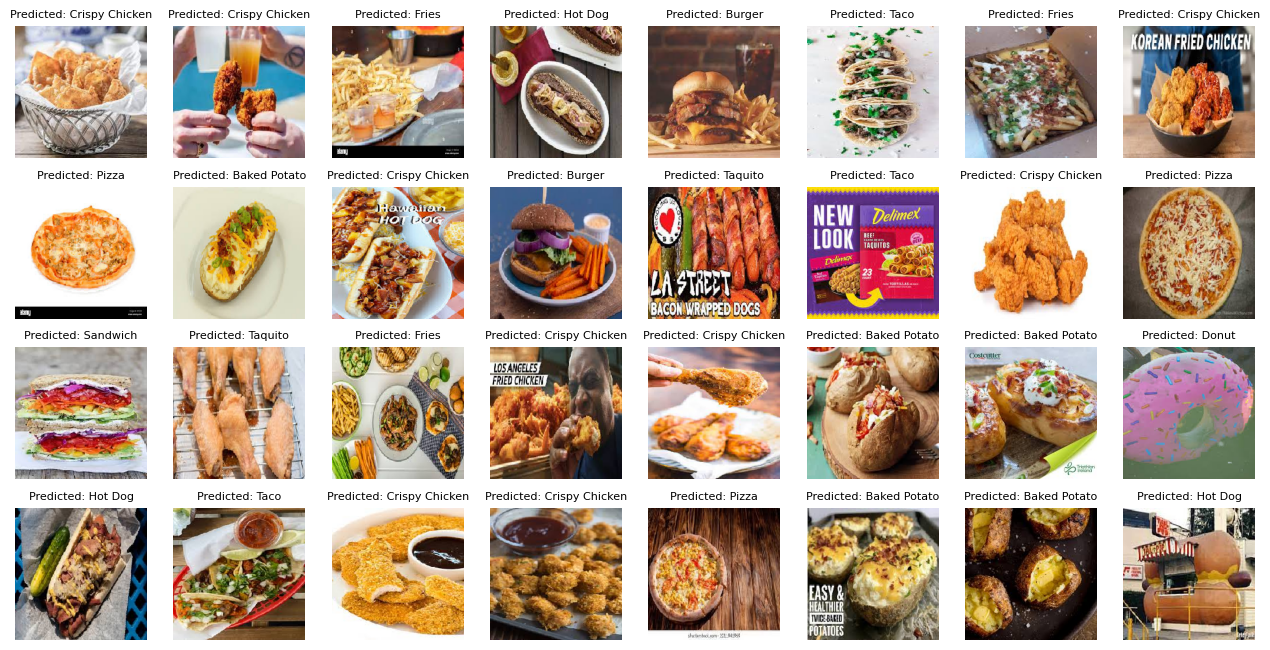

In [ ]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Get a batch of images and their true labels (if needed)
image_batch, true_labels_batch = next(evaluation_generator)

# Make predictions on the batch of images
predicted_labels_batch = model.predict(image_batch)

# Display the images along with their predicted labels
plt.figure(figsize=(16, 8))
for i in range(len(image_batch)):
    plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i])

    # Get the predicted label (index of the highest probability)
    predicted_label_index = np.argmax(predicted_labels_batch[i])

    # Map the predicted label index to the class label
    predicted_label = class_labels[predicted_label_index]

   # Display the predicted label with smaller text size
    plt.title(f'Predicted: {predicted_label}', fontsize=8)

    # Remove axis ticks and labels for a cleaner display
    plt.axis('off')

plt.show()

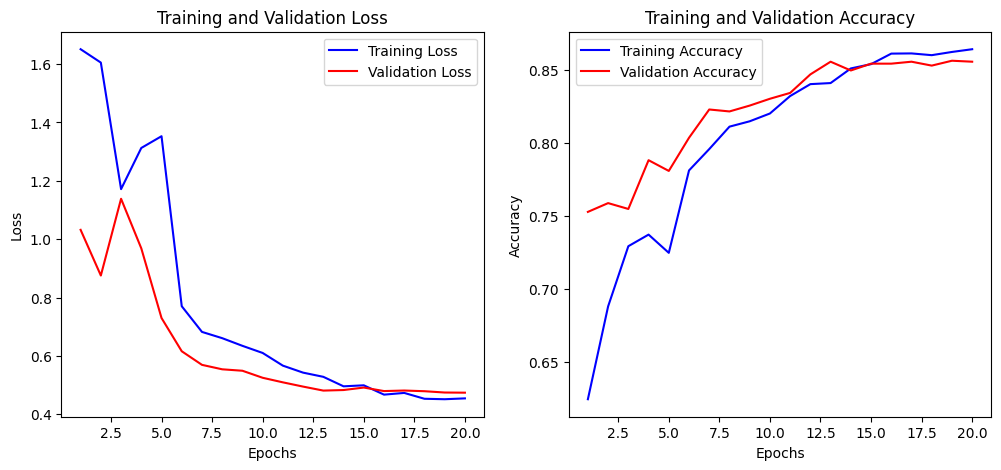

In [ ]:
# Access training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Confusion Matrix:** Visualize the confusion matrix to understand which classes are often confused with each other.

110/110 [==============================] - 8s 77ms/step


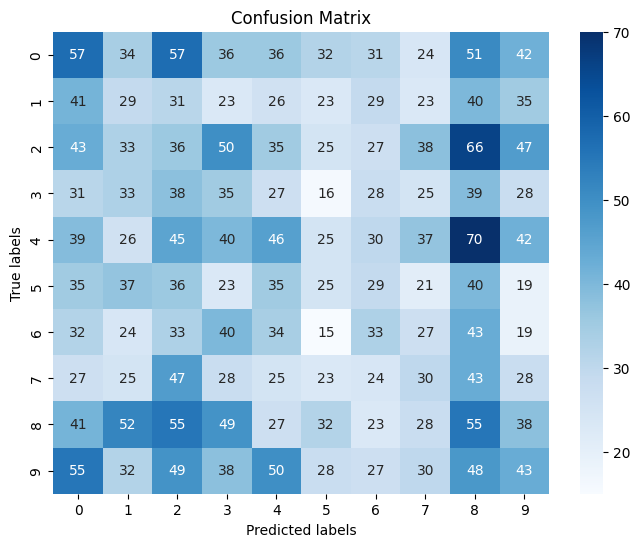

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the evaluation dataset
y_pred = model.predict(evaluation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = evaluation_generator.classes

# Create confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# **Visualizations of the Dataset**

In [ ]:
import os

**Class Distribution Visualization** : Visualize the distribution of classes in your dataset using a bar chart. This helps to understand if the dataset is balanced or skewed towards certain classes.

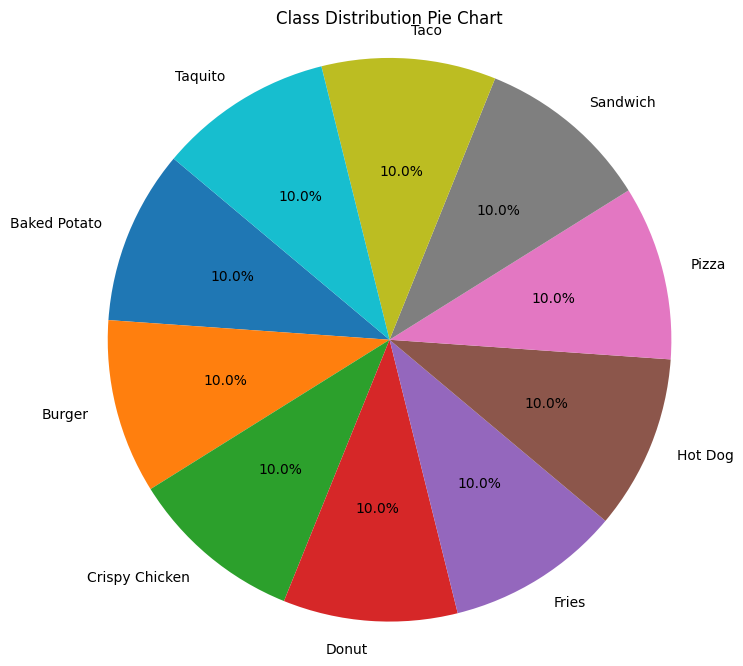

In [ ]:
import matplotlib.pyplot as plt

# Count the number of samples per class in the training dataset
class_counts = train_generator.classes
class_names = list(train_generator.class_indices.keys())

# Calculate the number of samples in each class
class_sample_counts = [np.sum(class_counts == i) for i in range(len(class_names))]

# Create a pie chart to visualize the class distribution
plt.figure(figsize=(8, 8))
plt.pie(class_sample_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution Pie Chart')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


**Data Distribution Across Train, Validation, and Test Sets:**
Visualize the distribution of data across the training, validation, and test sets to ensure that they are balanced.

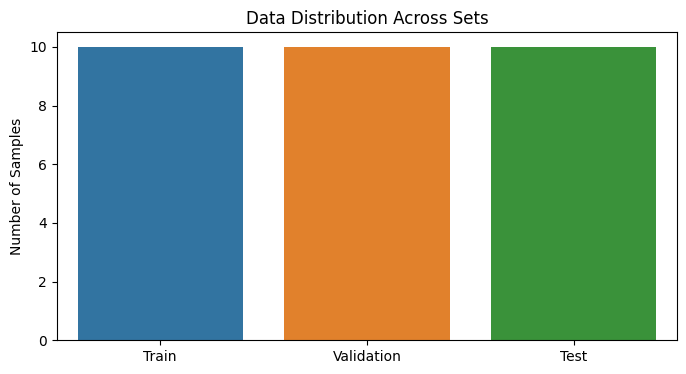

In [ ]:
# Get the number of samples in each set
train_count = len(os.listdir(training_path))
validation_count = len(os.listdir(validation_path))
evaluation_count = len(os.listdir(evaluation_path))

# Plot the distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=['Train', 'Validation', 'Test'], y=[train_count, validation_count, evaluation_count])
plt.title('Data Distribution Across Sets')
plt.ylabel('Number of Samples')
plt.show()

**Random Sample from a class**

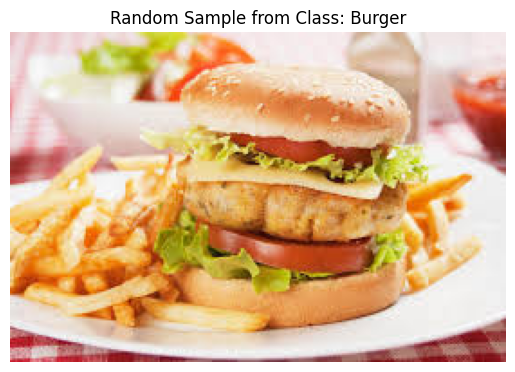

In [ ]:
import random
from PIL import Image

# Choose a random class
random_class = random.choice(class_names)

# Get a list of image file paths for that class
class_path = os.path.join(training_path, random_class)
image_files = os.listdir(class_path)

# Choose a random image from the class
random_image = random.choice(image_files)

# Load and display the random image
image_path = os.path.join(class_path, random_image)
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Random Sample from Class: {random_class}')
plt.axis('off')
plt.show()

**Image Size Distribution:** Visualize the distribution of image sizes (width and height) in your dataset. This can help you determine if all images have consistent sizes or if there is significant variation.

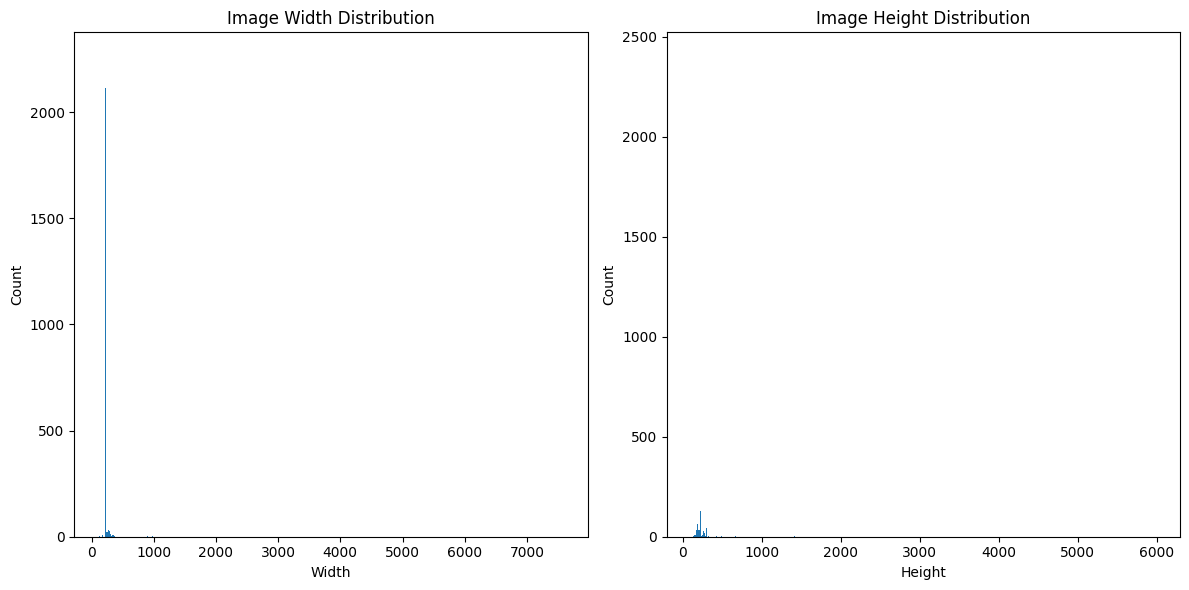

In [ ]:
from collections import defaultdict

# Create dictionaries to store width and height counts
width_counts = defaultdict(int)
height_counts = defaultdict(int)

# Iterate through the dataset to count image sizes
for class_name in class_names:
    class_path = os.path.join(training_path, class_name)
    image_files = os.listdir(class_path)
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path)
        width, height = image.size
        width_counts[width] += 1
        height_counts[height] += 1

# Plot the distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(width_counts.keys(), width_counts.values())
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(height_counts.keys(), height_counts.values())
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Count')

plt.tight_layout()
plt.show()